In [2]:
import pandas as pd

# Load Data

In [230]:
CROPS = ['鳳梨-金鑽鳳梨', '香蕉', '青蔥-日蔥', '蓮霧-紅蓮霧', '芽菜類-黃豆牙', '南瓜-木瓜形', '大蒜-蒜仁', '小白菜-土白菜', '木瓜-網室紅肉', '洋香瓜-網狀紅肉']
CROPS_NAME = {'鳳梨-金鑽鳳梨': '鳳梨', '香蕉': '香蕉', '青蔥-日蔥': '蔥', '蓮霧-紅蓮霧': '蓮霧', 
              '芽菜類-黃豆牙': '芽菜類', '南瓜-木瓜形': '南瓜', '大蒜-蒜仁': '大蒜', '小白菜-土白菜': '小白菜', 
              '木瓜-網室紅肉': '木瓜', '洋香瓜-網狀紅肉': '洋香瓜'}
CROPS_LIST = [v for k, v in CROPS_NAME.items()]


price = {v: {'prophet': {}, 'ARIMA': {}, 'LSTM-1': {}} for k, v in CROPS_NAME.items()}
return_1 = {v: {'prophet': {}, 'ARIMA': {}, 'LSTM-1': {}} for k, v in CROPS_NAME.items()}
return_3 = {v: {'prophet': {}, 'ARIMA': {}, 'LSTM-1': {}} for k, v in CROPS_NAME.items()}

# create df with datetime
start_date = pd.to_datetime('2019-01-01')

day_seq = []

while start_date < pd.to_datetime('2020-01-01'):
  day_seq.append(start_date)
  start_date += pd.DateOffset(days=1)

template = pd.DataFrame.from_dict({'DateTime': day_seq})
# template = template.set_index('DateTime')

## Load prophet results

In [231]:
import os

for f in os.listdir('../prophet/result/result_csv'):
  data = pd.read_csv(f'../prophet/result/result_csv/{f}')
  data['DateTime'] = pd.to_datetime(data['DateTime'])
  data = data[['DateTime', 'predict']]
  data = data.rename({'predict': 'prophet'}, axis='columns')
  
  true_data = pd.read_csv(f'../prophet/result/result_csv/{f}')
  true_data['DateTime'] = pd.to_datetime(true_data['DateTime'])

  pos = [True if n in f else False for n in CROPS]
  name = CROPS_NAME[CROPS[pos.index(True)]]
  
  if '平均價' in f:
    price[name]['prophet'] = data
    price[name]['price'] = true_data[['DateTime', '平均價']]
  elif '3_day_return' in f:
    return_3[name]['prophet'] = data
    return_3[name]['3_day_return'] = true_data[['DateTime', '3_day_return']]

## Load ARIMA results

In [232]:
for f in os.listdir('results/ARIMA'):
  data = pd.read_csv(f'results/ARIMA/{f}')
  data['DateTime'] = pd.to_datetime(data['DateTime'])
  data = data[['DateTime', 'predict']]
  data = data.rename({'predict': 'ARIMA'}, axis='columns')
  
  pos = [True if n in f else False for n in CROPS_LIST]
  name = CROPS_LIST[pos.index(True)]
  
  if 'price' in f:
    price[name]['ARIMA'] = data
  elif '3DayReturn' in f:
    return_3[name]['ARIMA'] = data

## Load LSTM-1 results

In [ ]:
for f in os.listdir('results/LSTM_han'):
  if '3_day_return' in f:
    pred_tag = '3_day_return_pred'
  elif 'Price' in f:
    pred_tag = 'Price_pred'
  
  data = pd.read_csv(f'results/LSTM_han/{f}')
  
  data = data[['date', pred_tag]]
  data = data.rename({pred_tag: 'LSTM-1', 'date': 'DateTime'}, axis='columns')
  data['DateTime'] = pd.to_datetime(data['DateTime'])
  
  
  pos = [True if n in f else False for n in CROPS_LIST]
  name = CROPS_LIST[pos.index(True)]
  
  if 'Price' in f:
    price[name]['LSTM-1'] = data
  elif '3_day_return' in f:
    return_3[name]['LSTM-1'] = data

## Load LSTM-2 results

In [234]:
for f in os.listdir('results/LSTM_boyu'):
  
  if 'fs' in f:
    continue
  
  if '3_day_return' in f:
    pred_tag = '3_day_return_pred'
  elif 'Price' in f:
    pred_tag = 'Price_pred'
  else:
    continue
  
  data = pd.read_csv(f'results/LSTM_boyu/{f}')
  
  data = data[['DateTime', 'Predict']]
  data = data.rename({'Predict': 'LSTM-2'}, axis='columns')
  data['DateTime'] = pd.to_datetime(data['DateTime'])
  
  pos = [True if n in f else False for n in CROPS_LIST]
  name = CROPS_LIST[pos.index(True)]
  
  if 'Price' in f:
    price[name]['LSTM-2'] = data
  elif '3_day_return' in f:
    return_3[name]['LSTM-2'] = data

## Load LSTM-2 fs

In [272]:
price_fs = {v: {'LSTM': {}, 'LSTM-fs': {}} for k, v in CROPS_NAME.items()}

for f in os.listdir('results/LSTM_boyu'):
  
  if '3_day_return' in f:
    pred_tag = '3_day_return_pred'
    continue
  elif 'Price' in f:
    pred_tag = 'Price_pred'
  else:
    continue
  
  data = pd.read_csv(f'results/LSTM_boyu/{f}')
  
  true_data = data[['DateTime', 'Original']]
  true_data = true_data.rename({'Original': 'price'}, axis='columns')
  true_data['DateTime'] = pd.to_datetime(true_data['DateTime'])
  
  
  data = data[['DateTime', 'Predict']]
  
  if 'fs' in f:
    data = data.rename({'Predict': 'LSTM-fs'}, axis='columns')
  else:
    data = data.rename({'Predict': 'LSTM'}, axis='columns')
  data['DateTime'] = pd.to_datetime(data['DateTime'])
  
  pos = [True if n in f else False for n in CROPS_LIST]
  name = CROPS_LIST[pos.index(True)]
  
  if 'fs' in f:
    price_fs[name]['LSTM-fs'] = data
  else:
    price_fs[name]['LSTM'] = data

  price_fs[name]['price'] = true_data

# Merge Data

## Plot line chart

In [186]:
import plotly.io as pio
pio.renderers.default = 'svg'
import plotly.graph_objects as go
from plotly.subplots import make_subplots

def plot(data, y_title='', target='', extra_tag=''):
    # Create traces
    fig = go.Figure()
    for c in data:
      if c != 'DateTime':
#         line = dict(width=4) if c == target else dict(width=2)
        line = dict(width=2)
        fig.add_trace(go.Scatter(x=data['DateTime'], y=data[c],
                            line=line,
                            name=c))
    fig.update_layout(
      title = y_title,
#       title = f'{self.pred_class} {self.target} 預測{extra_tag} - 2019',
      xaxis_title = "Date",
      yaxis_title = y_title,
      width=800,
      height=500
    )
    fig.show()

In [247]:
def grid_plot(data, title, target='', width=950):
  fig = make_subplots(rows=2, cols=2, #start_cell="bottom-left", 
                      subplot_titles=("LSTM-1", "LSTM-2", "ARIMA", "prophet",))
  truth_color = 'rgba(142, 159, 163, 0.75)' #'royalblue'
  
  # prophet
  fig.add_trace(go.Scatter(x=data['DateTime'], y=data[target],
                            line = dict(width=2, color=truth_color),
                            name=target),
                    col=2, row=2)
  fig.add_trace(go.Scatter(x=data['DateTime'], y=data['prophet'],
                            mode='lines',
                            name='prophet'), 
                    col=2, row=2)
  
  # ARIMA
  fig.add_trace(go.Scatter(x=data['DateTime'], y=data[target],
                            line = dict(width=2, color=truth_color),
                            name=target,
                            showlegend=False),
                    col=1, row=2)
  fig.add_trace(go.Scatter(x=data['DateTime'], y=data['ARIMA'],
                            mode='lines',
                            name='ARIMA'), 
                    col=1, row=2)
  
  
  # LSTM-1
  fig.add_trace(go.Scatter(x=data['DateTime'], y=data[target],
                            line = dict(width=2, color=truth_color),
                            name=target,
                            showlegend=False), 
                    col=1, row=1)
  fig.add_trace(go.Scatter(x=data['DateTime'], y=data['LSTM-1'],
                            mode='lines',
                            name='LSTM-1'), 
                    col=1, row=1)
  
  # LSTM-2
  fig.add_trace(go.Scatter(x=data['DateTime'], y=data[target],
                            line = dict(width=2, color=truth_color),
                            name=target,
                            showlegend=False), 
                    col=2, row=1)
  fig.add_trace(go.Scatter(x=data['DateTime'], y=data['LSTM-2'],
                            mode='lines',
                            name='LSTM-2'), 
                    col=2, row=1)
  
  
  
  fig.update_layout(
      title = title
    )

  fig.show(width=width, height=600)

In [255]:
def compare_plot(data, title, target='', width=950):
  fig = make_subplots(rows=2, cols=1, 
                      subplot_titles=("LSTM", "LSTM-fs"))
  truth_color = 'rgba(142, 159, 163, 0.75)' #'royalblue'
  
  # LSTM
  fig.add_trace(go.Scatter(x=data['DateTime'], y=data[target],
                            line = dict(width=2, color=truth_color),
                            name=target),
                    col=1, row=1)
  fig.add_trace(go.Scatter(x=data['DateTime'], y=data['LSTM'],
                            mode='lines',
                            name='LSTM'), 
                    col=1, row=1)
  
  # LSTM-fs
  fig.add_trace(go.Scatter(x=data['DateTime'], y=data[target],
                            line = dict(width=2, color=truth_color),
                            name=target,
                            showlegend=False),
                    col=1, row=2)
  fig.add_trace(go.Scatter(x=data['DateTime'], y=data['LSTM-fs'],
                            mode='lines',
                            name='LSTM-fs'), 
                    col=1, row=2)
  
  
  fig.update_layout(title = title)

  fig.show(width=width, height=600)

## Price - Summary plot (all together)

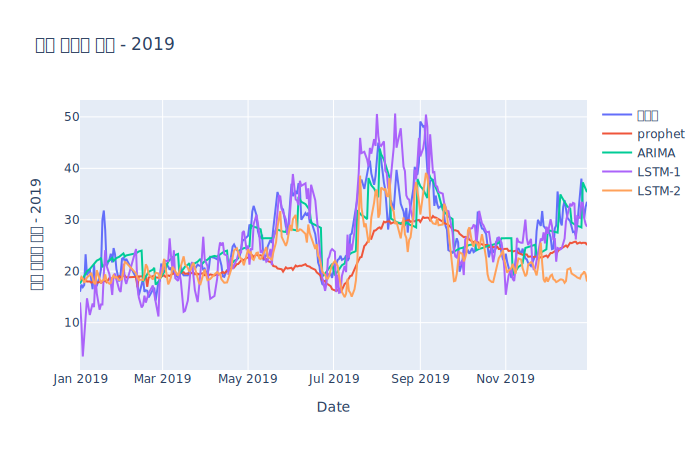

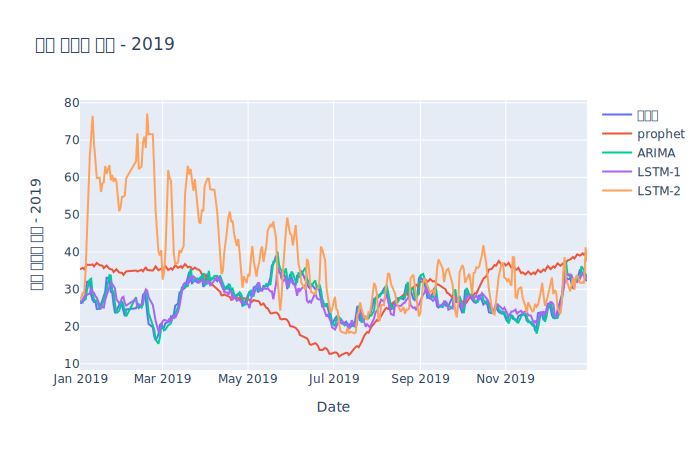

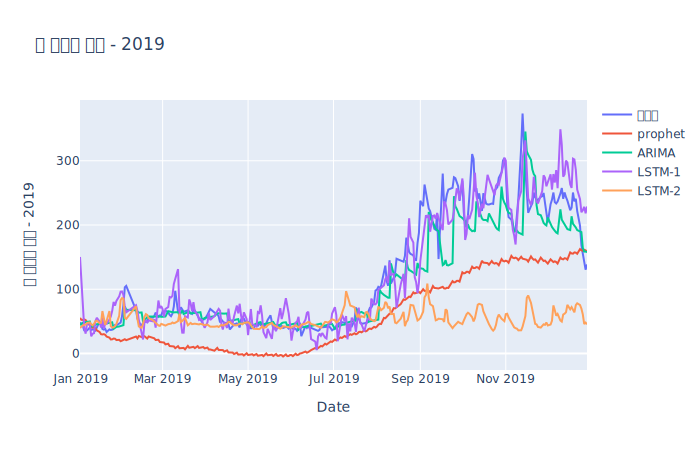

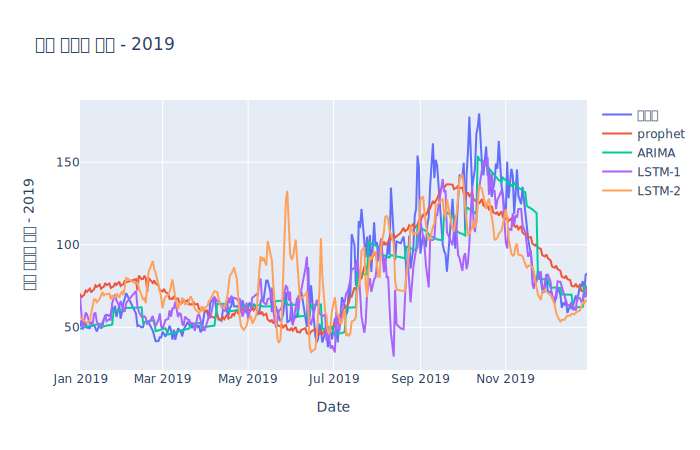

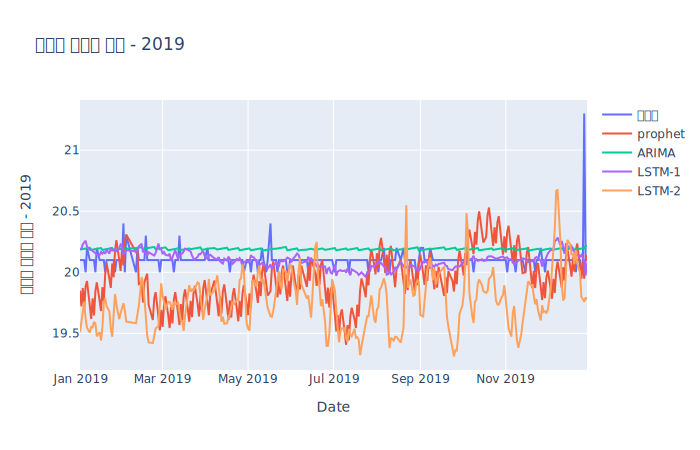

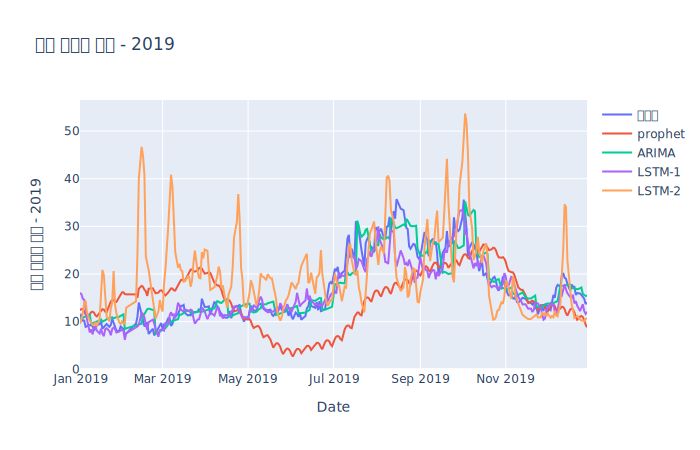

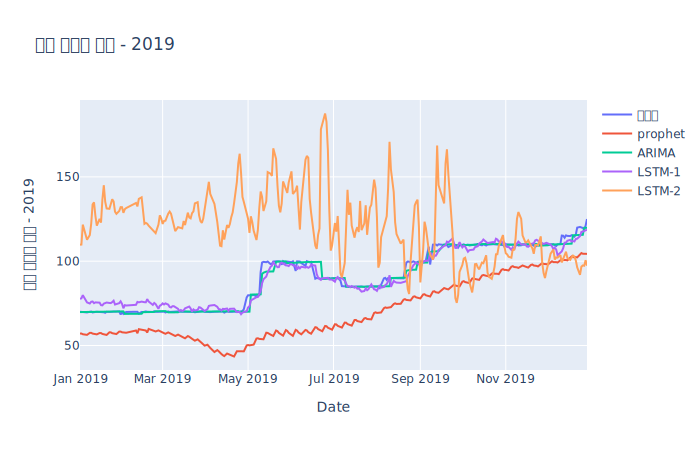

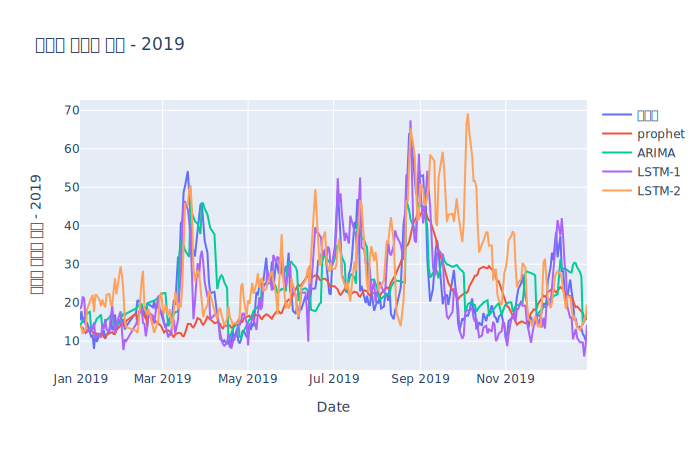

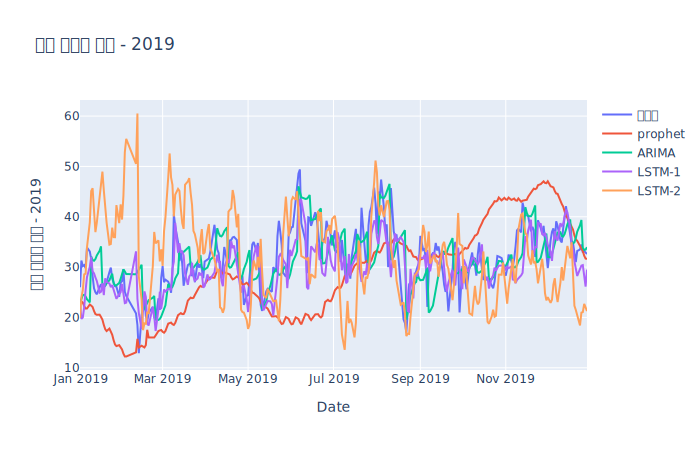

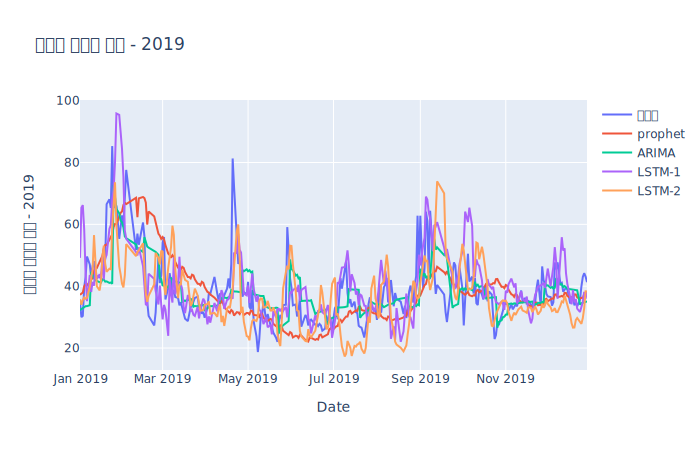

In [218]:
for c in price:
  # join all the data
  result = price[c]['price']
  for m in price[c]:
    if m != 'price':
      result = result.merge(price[c][m], on='DateTime')
#   plot(result, f'{self.pred_class} {self.target} 預測{extra_tag} - 2019')
  target = '平均價'
  plot(result, f'{c} {target} 預測 - 2019', target=target)

# Price - Grid plot

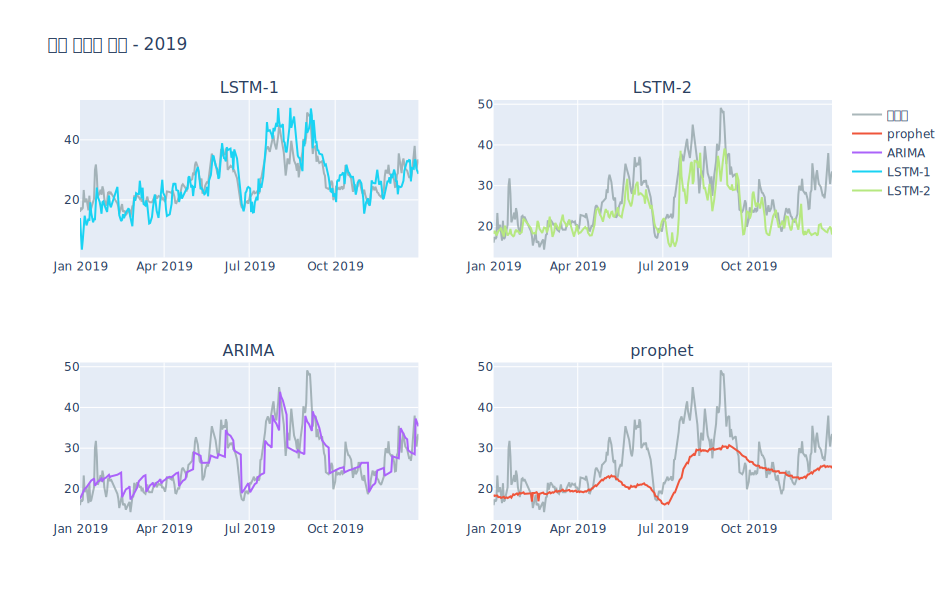

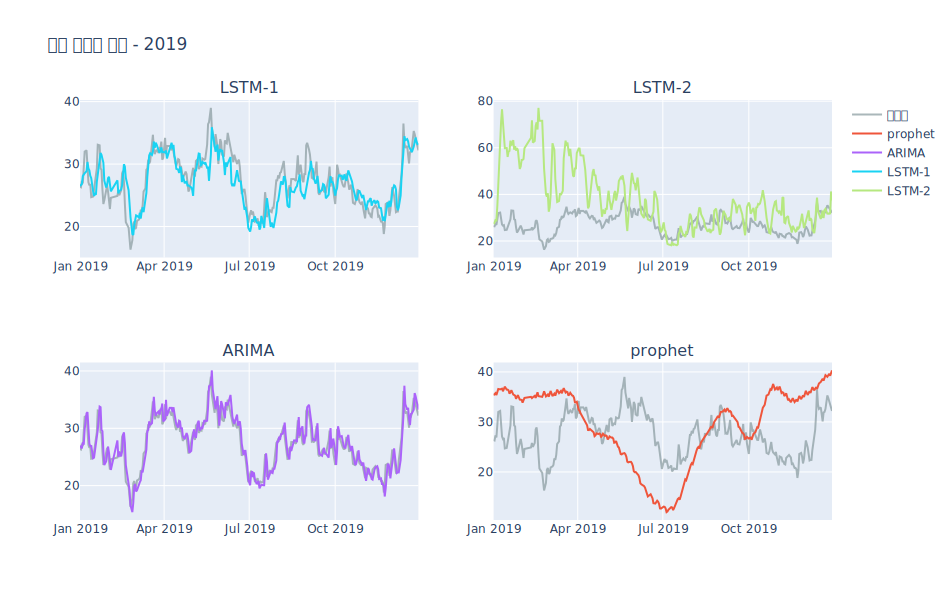

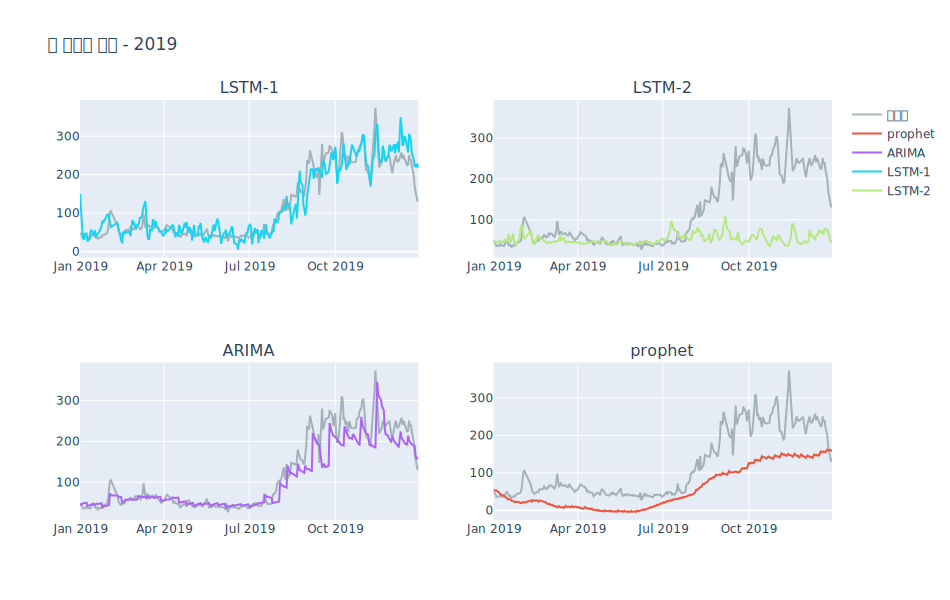

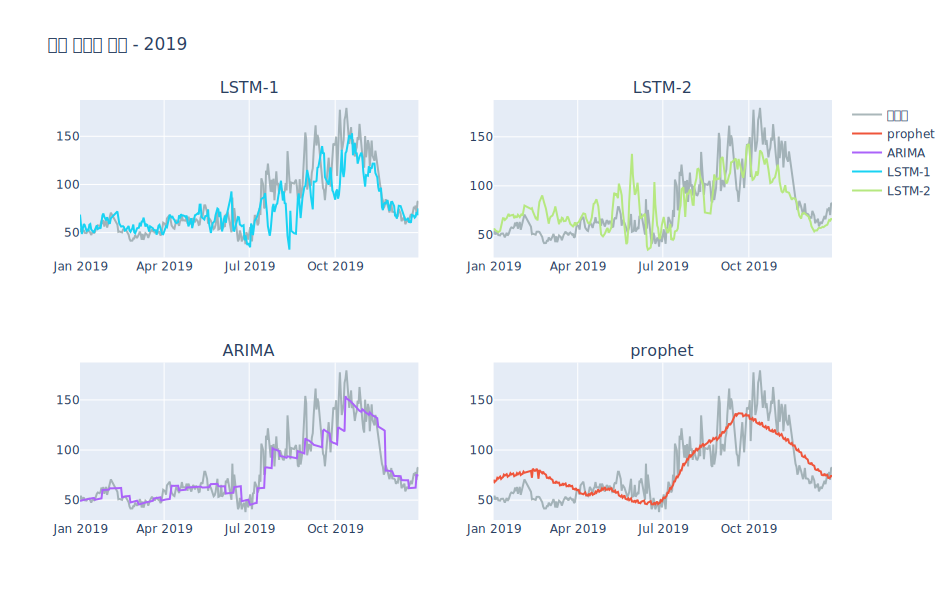

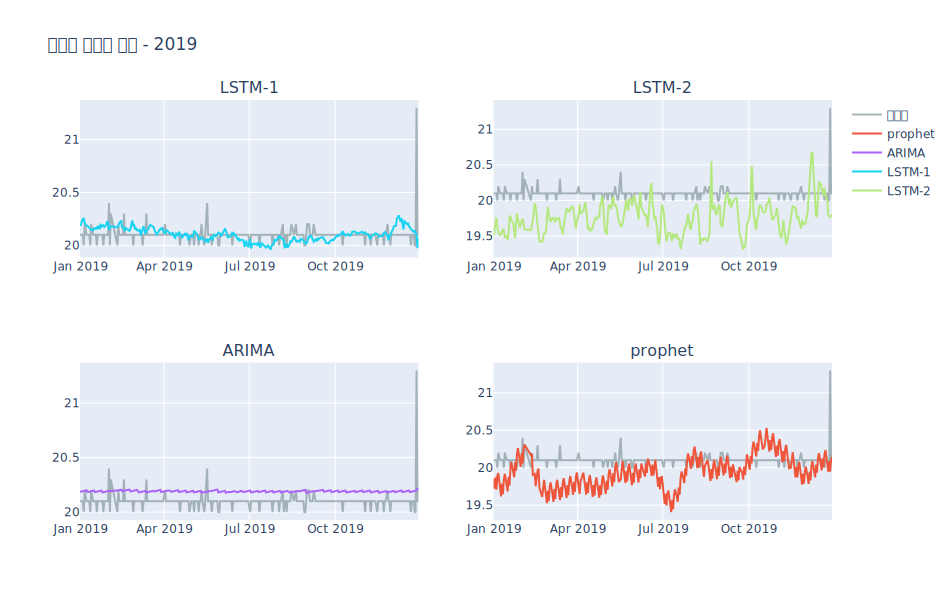

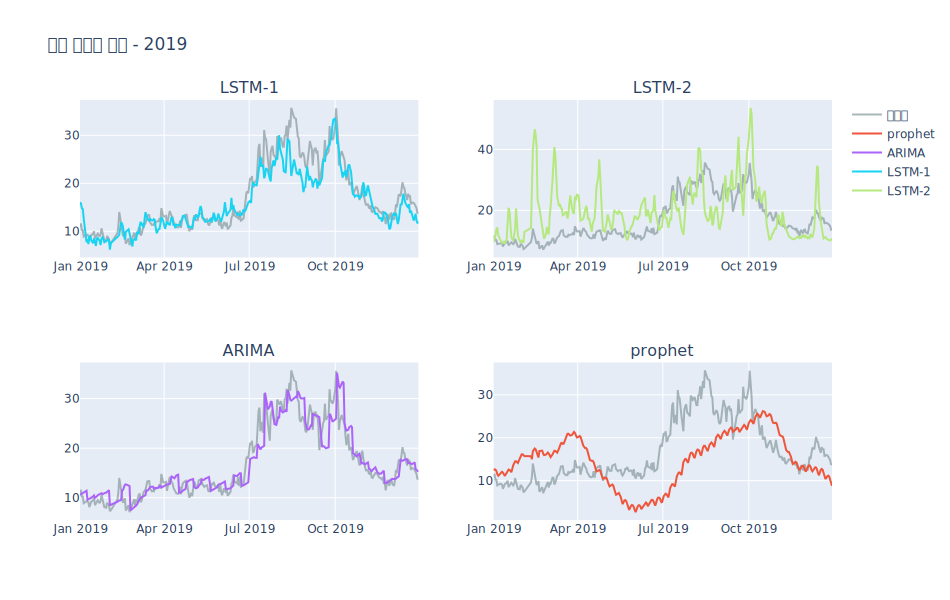

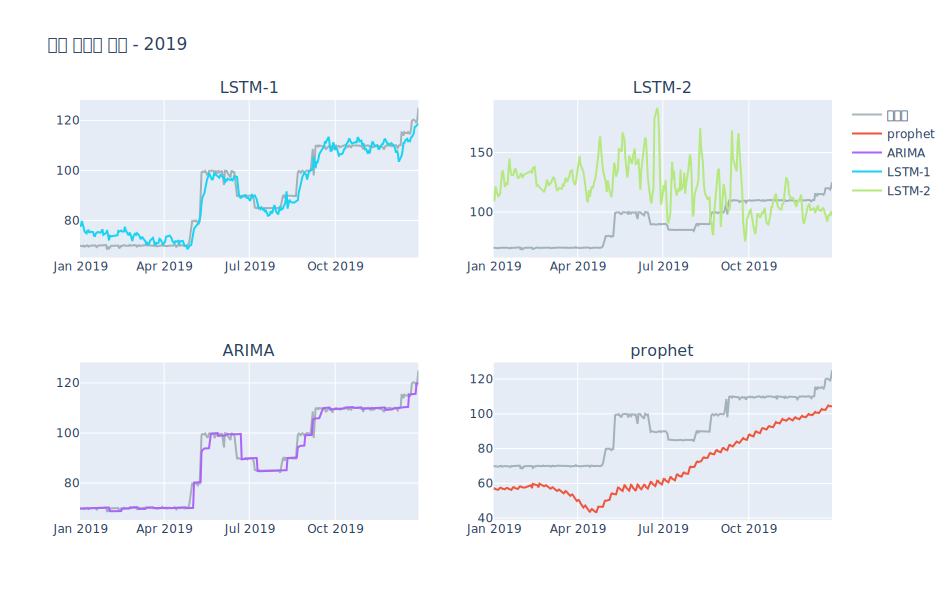

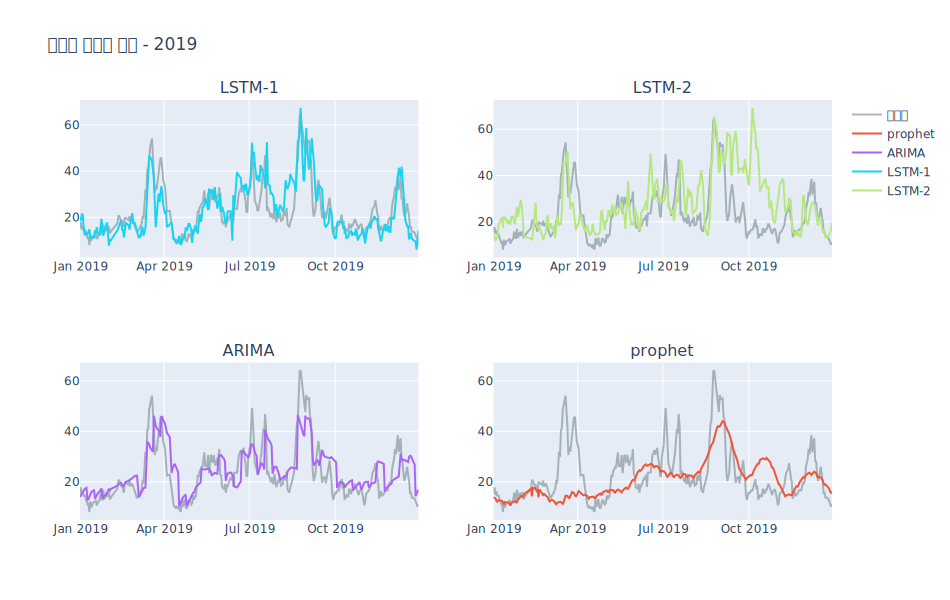

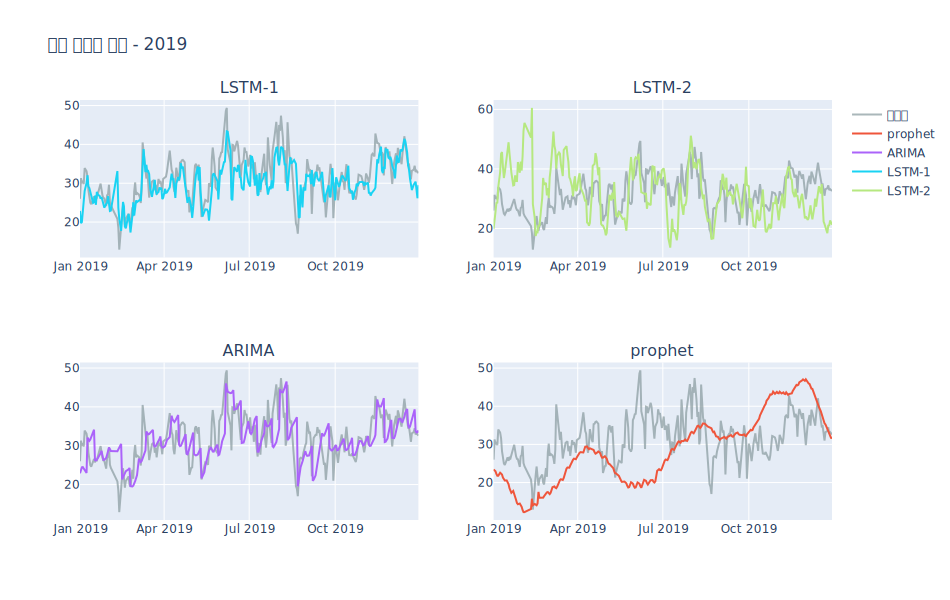

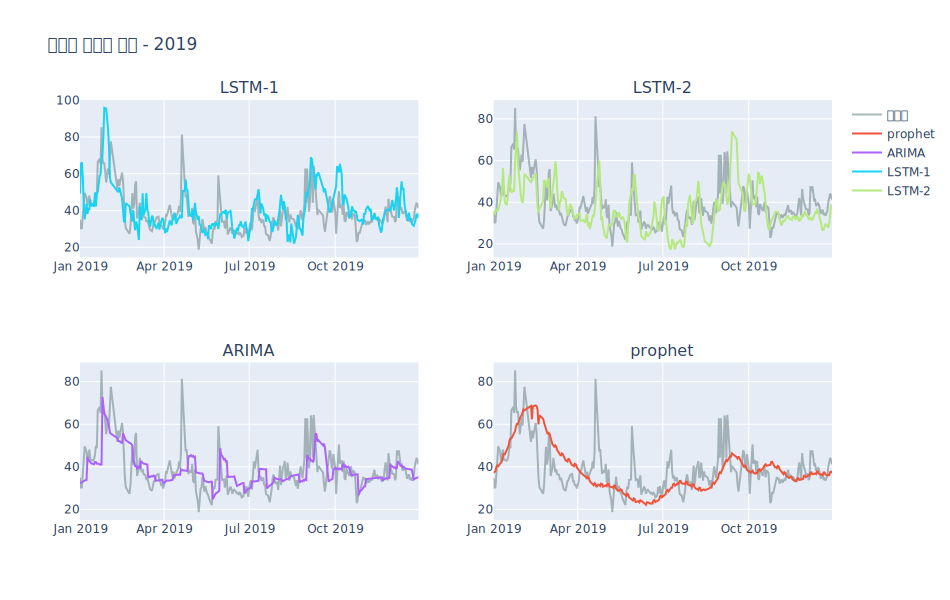

In [224]:
for c in price:
  # join all the data
  result = price[c]['price']
  for m in price[c]:
    if m != 'price':
      result = result.merge(price[c][m], on='DateTime')
  target = '平均價'
  grid_plot(result, f'{c} {target} 預測 - 2019', target=target)
#  break

# 3 Day Return - Grid Plot

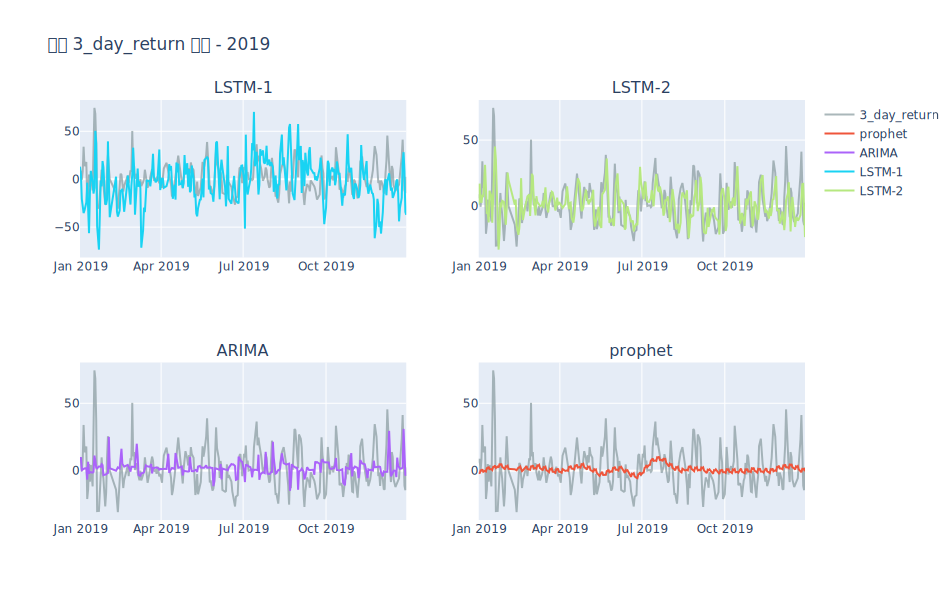

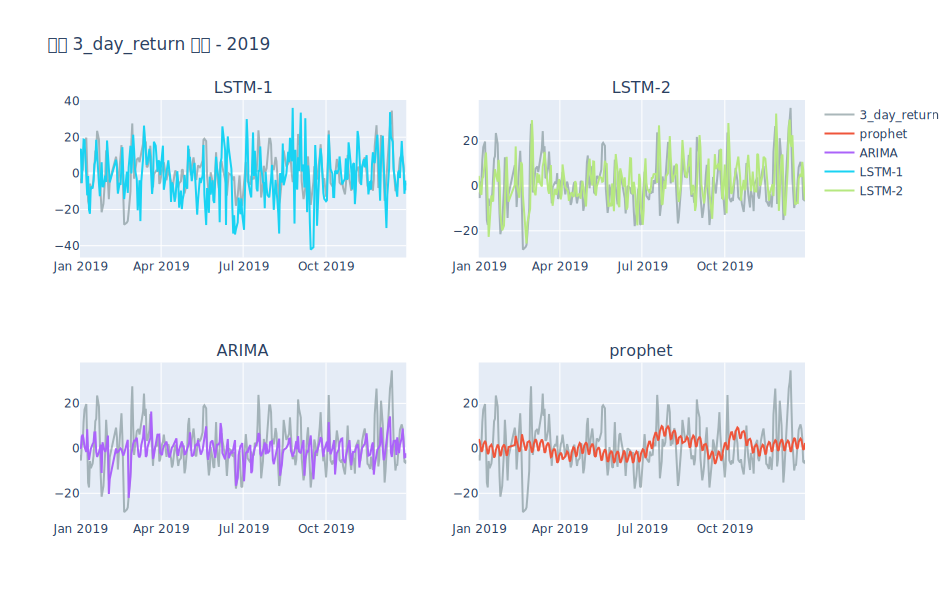

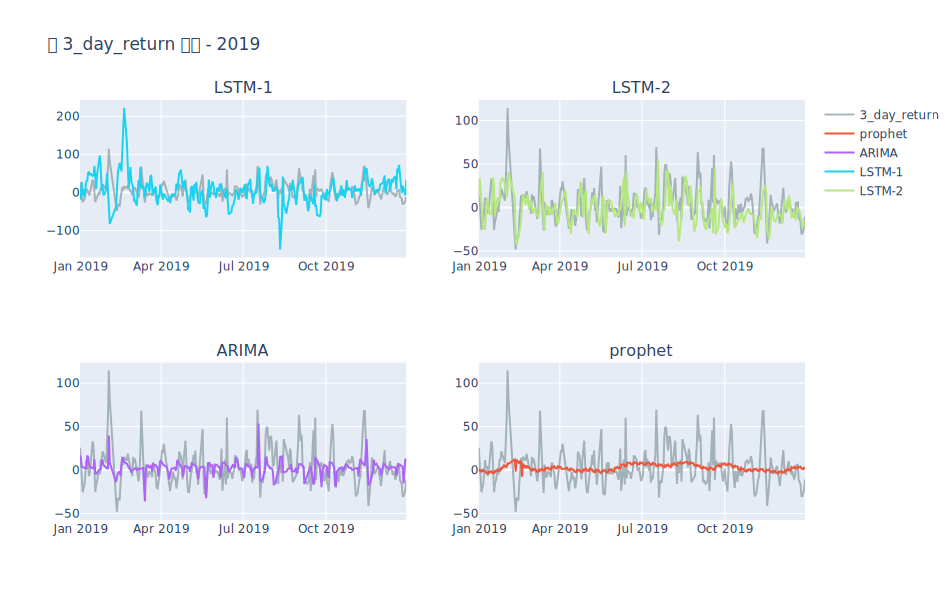

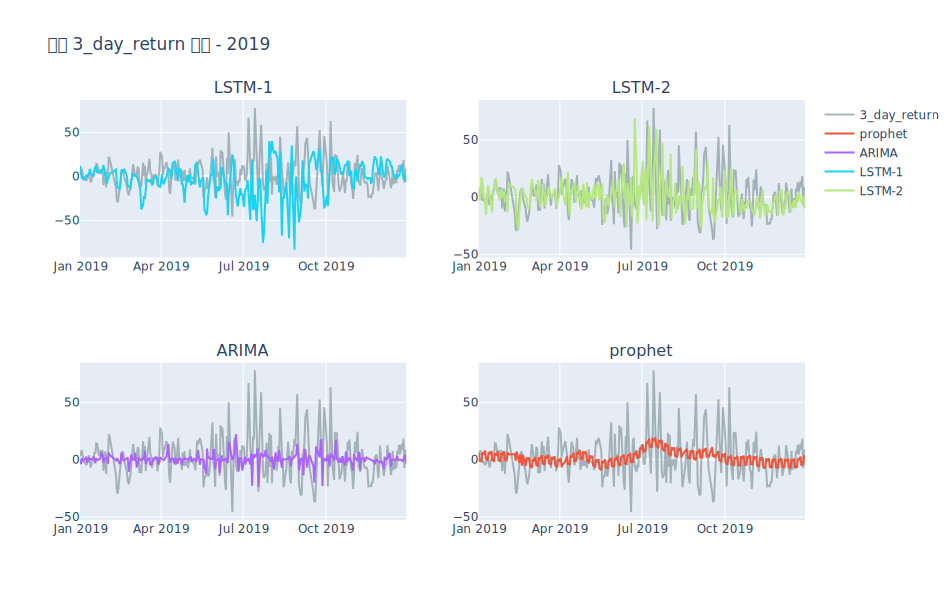

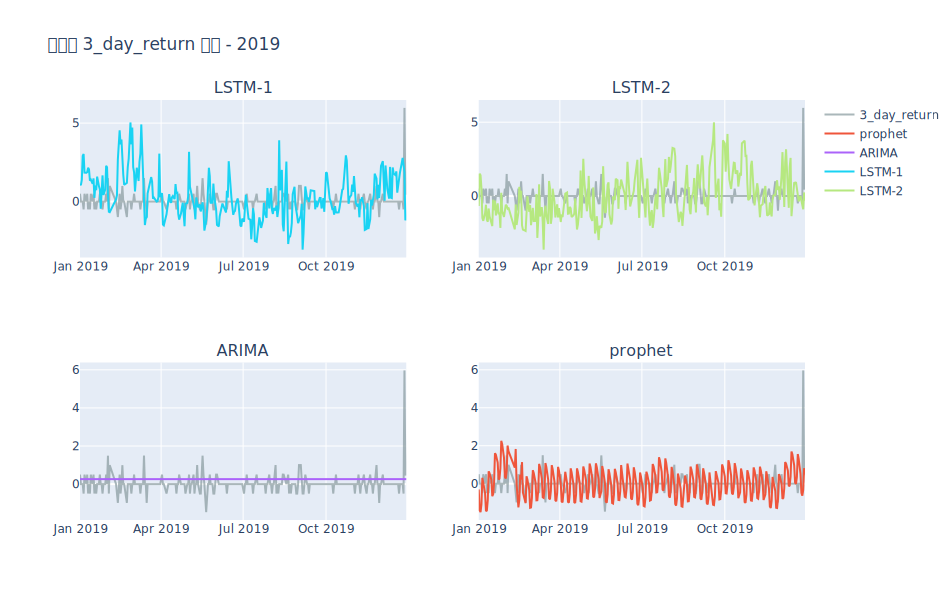

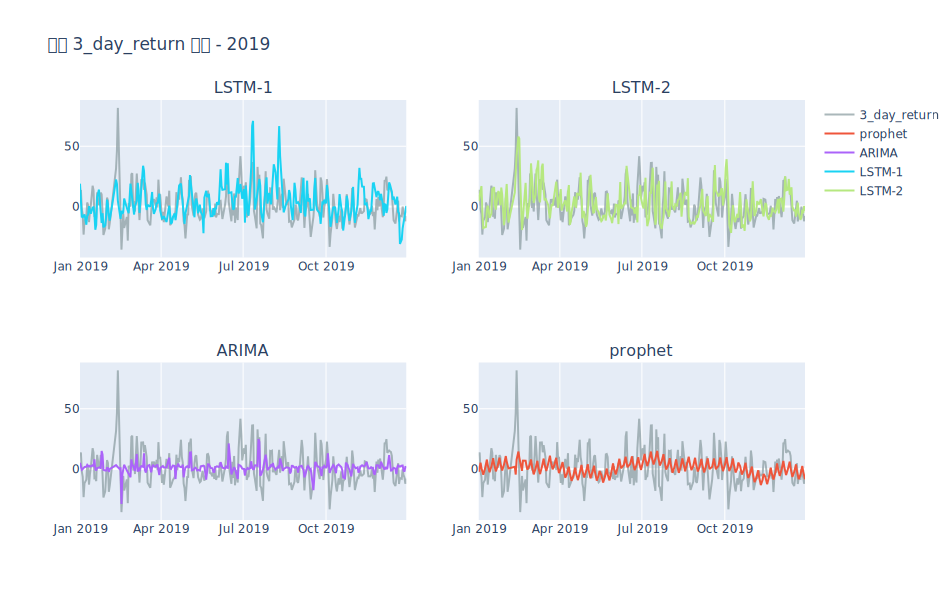

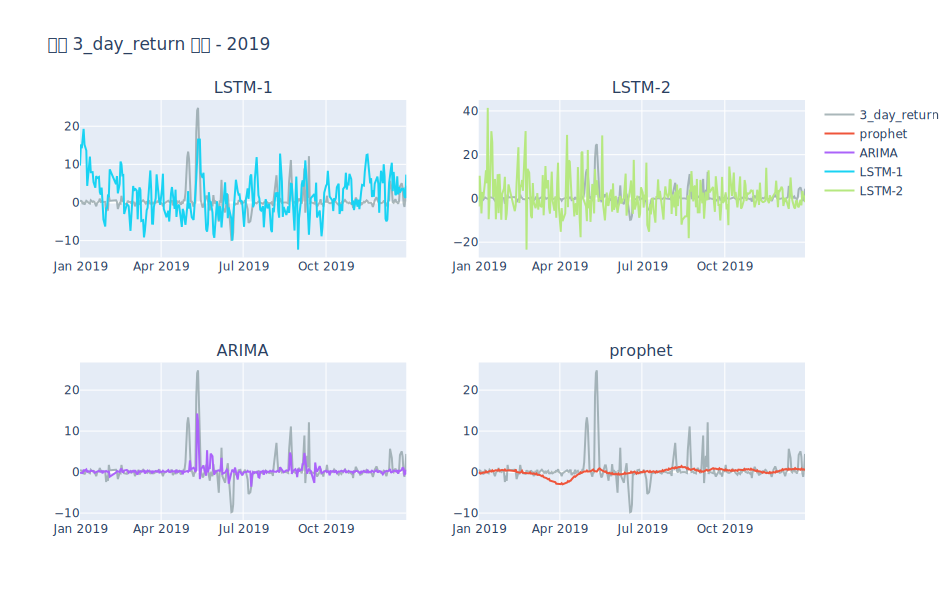

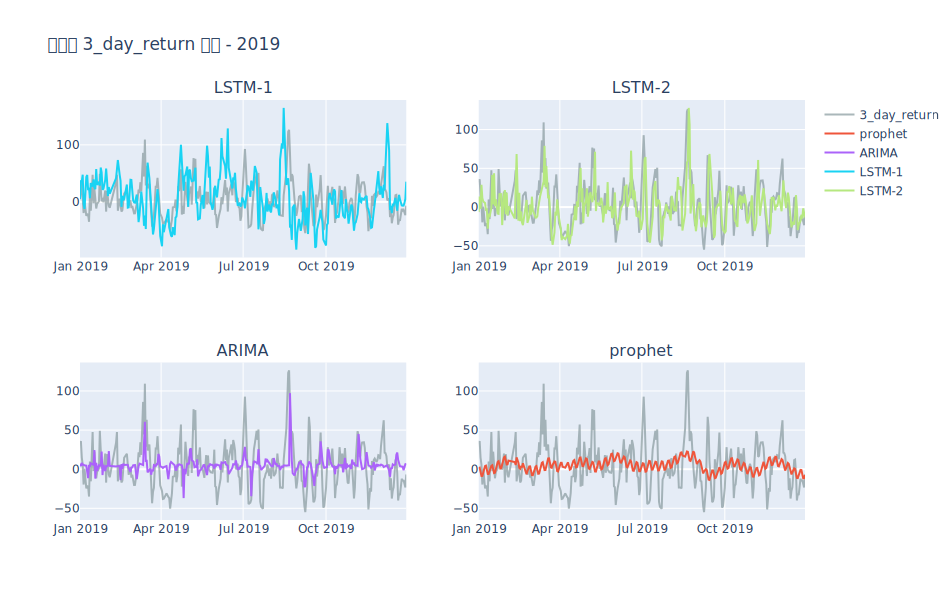

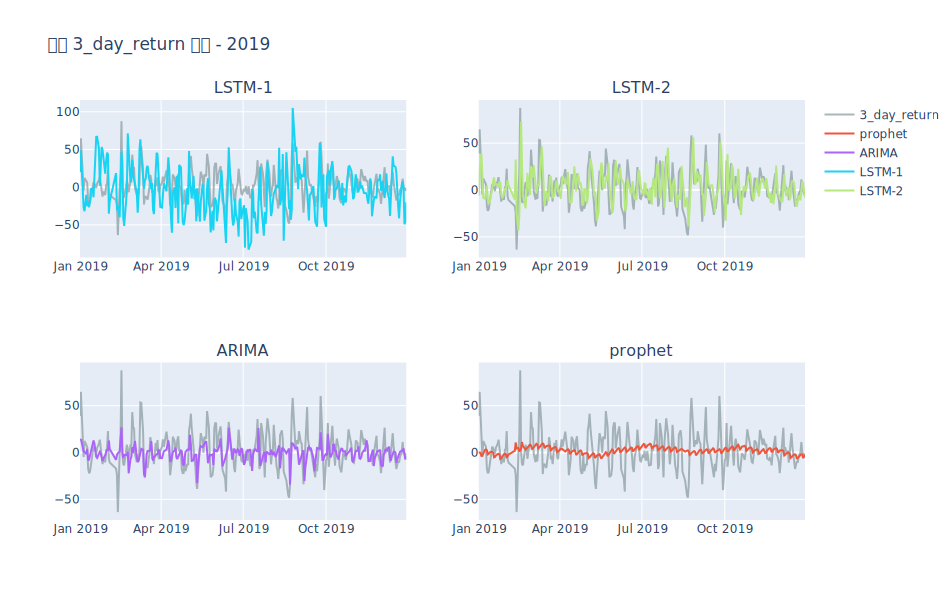

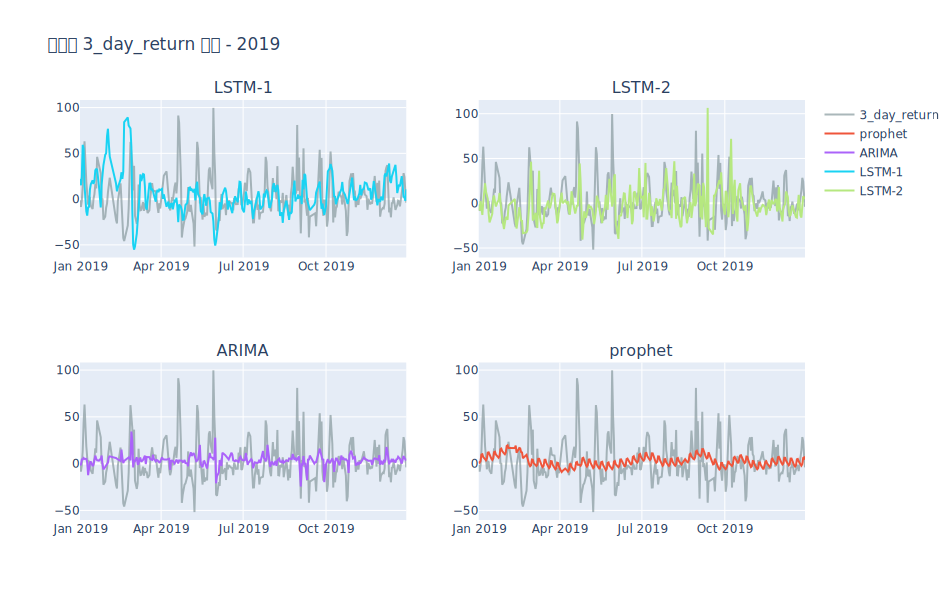

In [252]:
for c in return_3:
  # join all the data
  result = return_3[c]['3_day_return']
  for m in return_3[c]:
    if m != '3_day_return':
      result = result.merge(return_3[c][m], on='DateTime')
  target = '3_day_return'
  grid_plot(result, f'{c} {target} 預測 - 2019', target=target, width=950)

# Comparison - LSTM w/wo Feature Selection

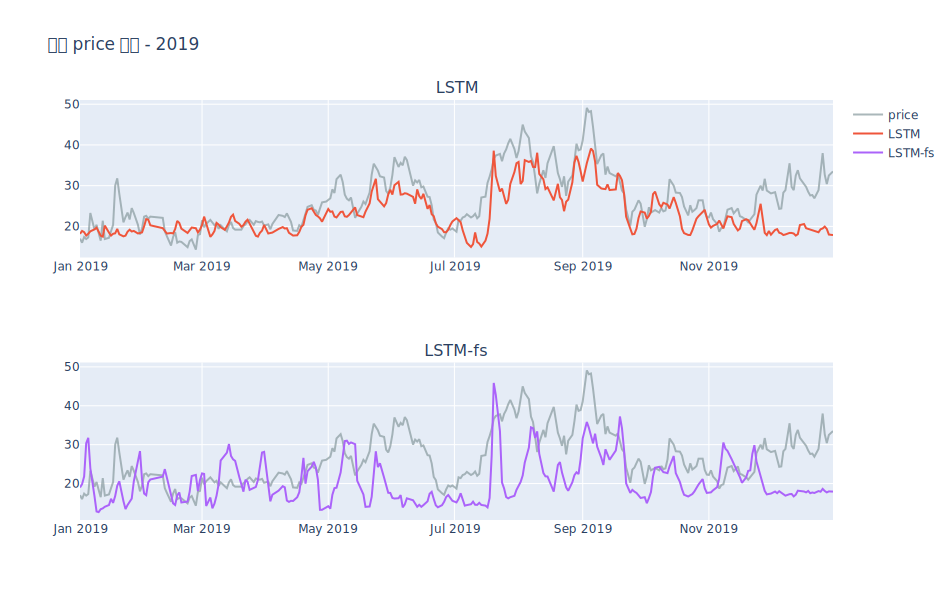

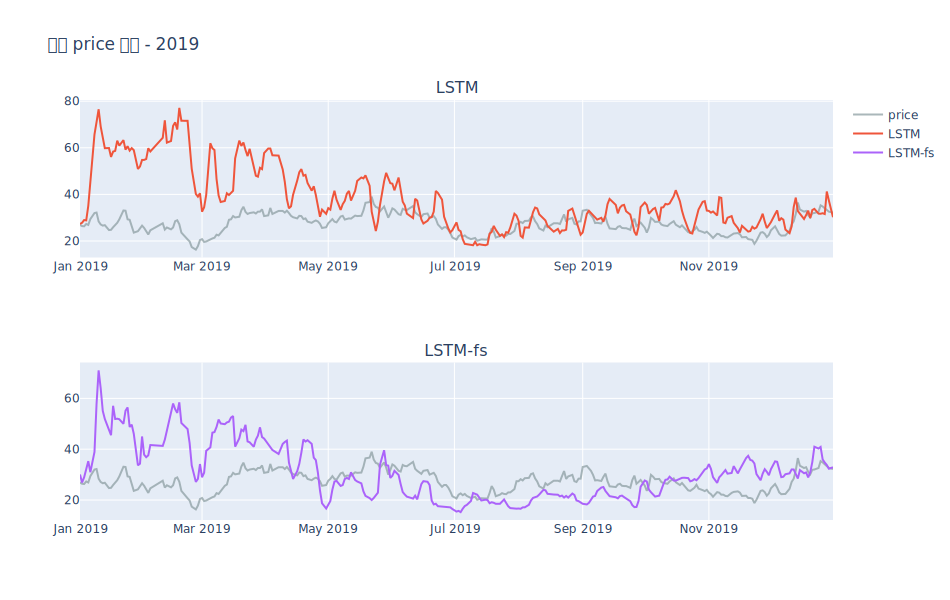

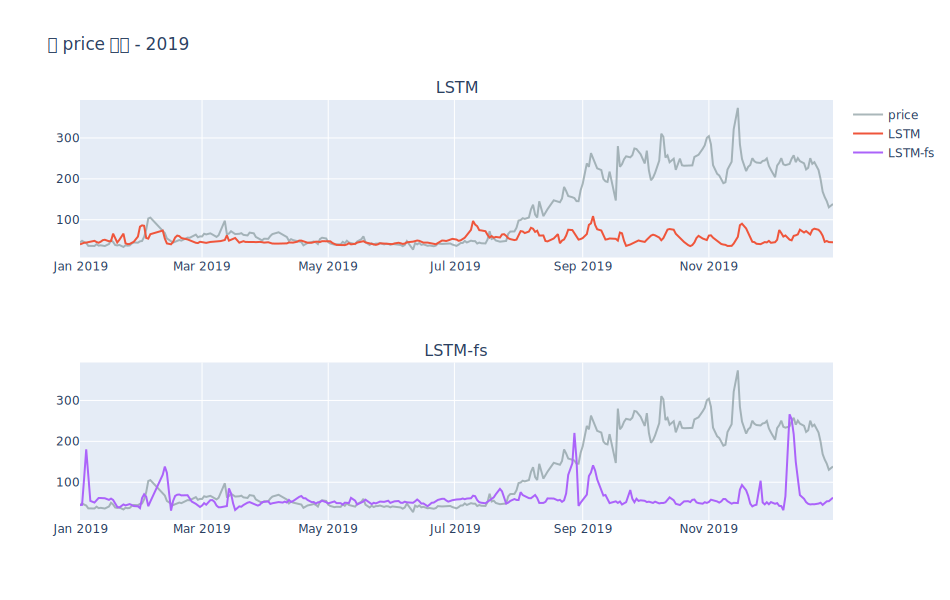

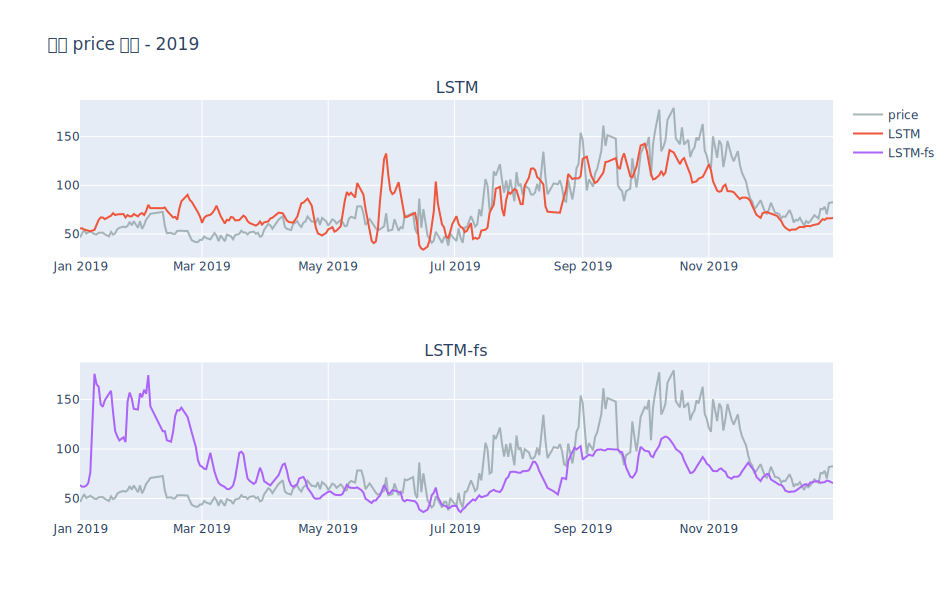

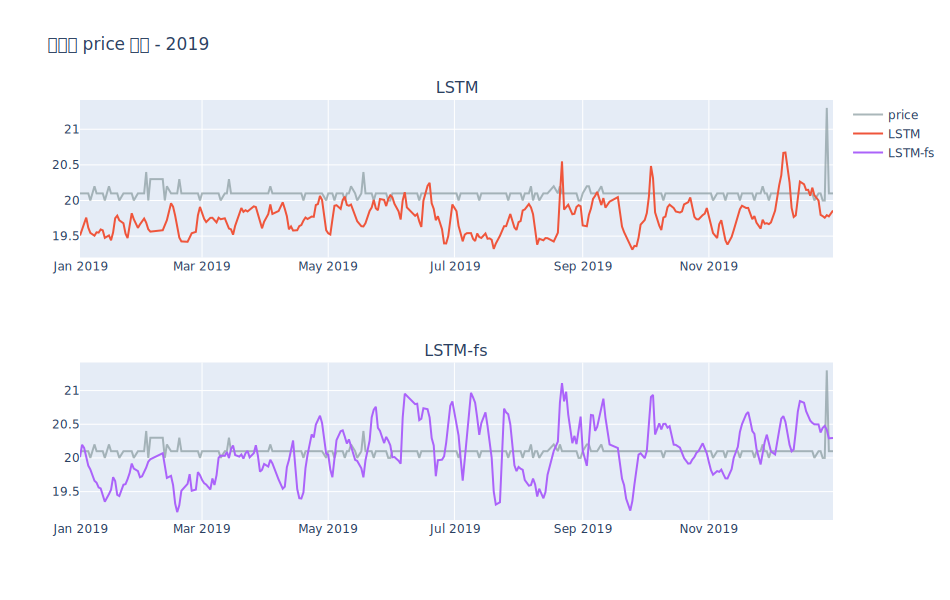

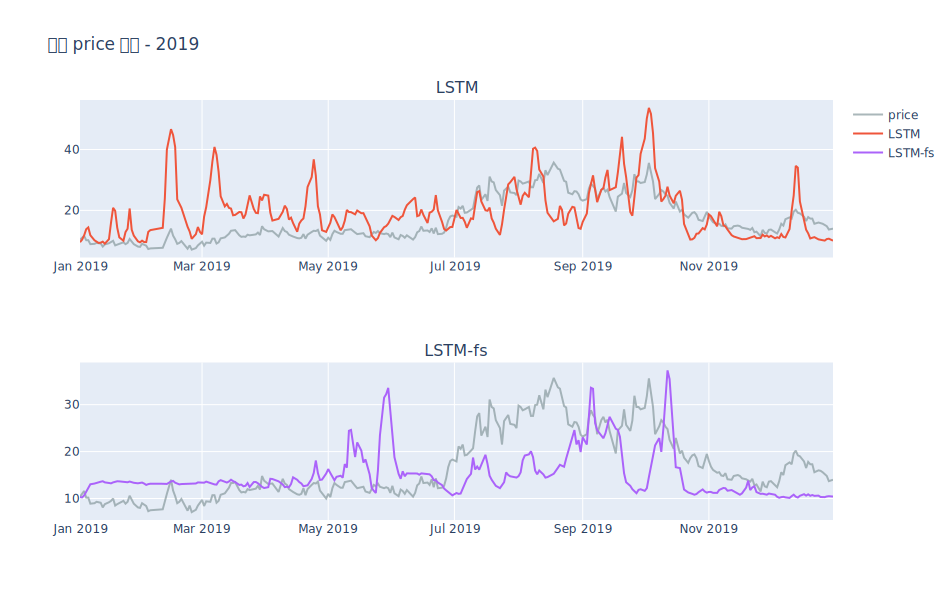

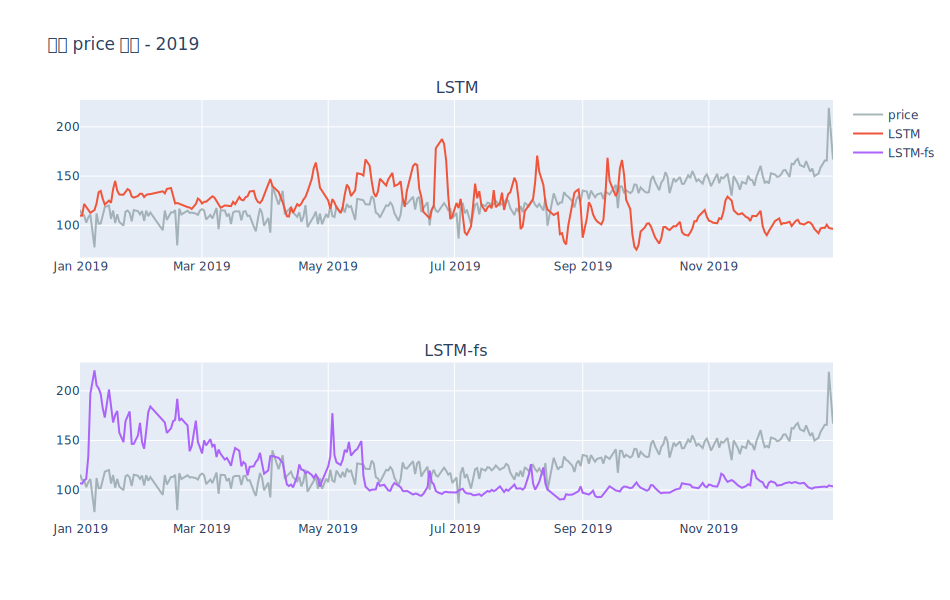

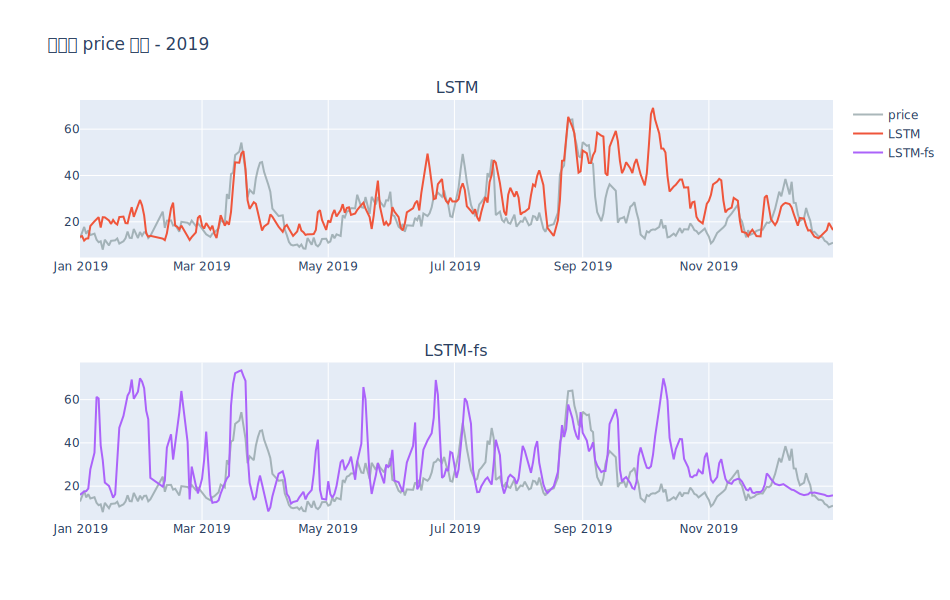

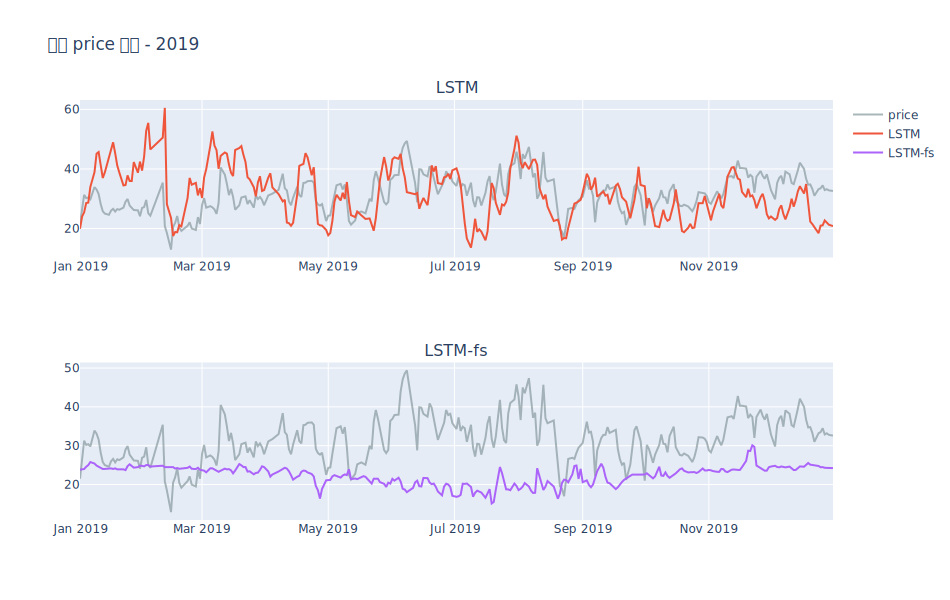

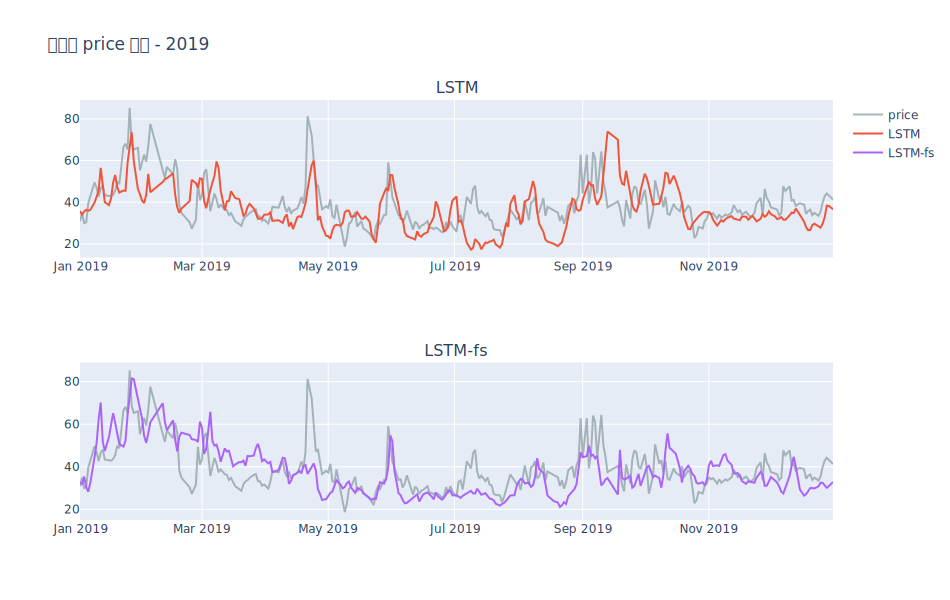

In [273]:
for c in price_fs:
  # join all the data
  result = price_fs[c]['price']
  for m in price_fs[c]:
    if m != 'price':
      result = result.merge(price_fs[c][m], on='DateTime')
#   print(result)
  target = 'price'
  compare_plot(result, f'{c} {target} 預測 - 2019', target=target, width=950)